<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [2]:
!pip install --user sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
trans_df = pd.read_csv('data/wayuu/COMP_NDU.csv')
print(trans_df.shape)
print(trans_df.columns)

(79248, 2)
Index(['esp', 'wayuu'], dtype='object')


In [5]:
df_train, df_devtest = train_test_split(trans_df, test_size=2000, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=1000, random_state=42)

In [6]:
df_train.head()

,esp,wayuu
69325,lo hicieron tres veces entonces me dijeron que...,apunuintua naa'inruin tia nakulajaapa tanainje...
70501,a como demuestra el ejemplo de los israelitas ...,jamusu watujaaka saa'u eein supula ichein waa'...
53759,cuando el libro de la ley fue encontrado y jos...,wanaa sumaa saashaje'ennuin numuin josias tu p...
30184,ellos eran desertores,nayakana o'uwataashi
2310,no soy yo libre no soy apostol no he vist...,eeshii waneeirua eekai ayoujain tu ta'yataaink...


In [7]:
df_dev.head()

,esp,wayuu
63433,en este articulo veremos como la biblia nos pu...,sunain ekirajaayakat tuu wekirajaweeru anain t...
44778,a que cosas pasaron el dia de la pascua del de...,kasa alataka su'unnaa tu pascua eejatkat so'u ...
14149,hazlo tu mismo,paa'inraa piakat
19497,como estuvo tu dia,jamusu saa'n pukuwa'ipa so'ika'i
46567,un grupo vivira para siempre en el cielo,eeshii na kepiainjanakana chaa iipunaa


In [8]:
df_test.head()

,esp,wayuu
7545,en cambio tu no has querido compadecerte de tu...,mojushiisu tamuin nnojoluin pumuliajuin chi pu...
6884,"pedro, que lo habia seguido de lejos hasta la ...","otta mushia pedro, nunanajakalaka nuchiirua ka..."
32354,al dia siguiente,wattamuin
14777,estoy enfadado contigo,ashichishi taya muin
43385,a que necesitamos para entrar en el nuevo mundo,kasa cho'ujaaka wamuin supula walatuinjanain s...


# 2. How well does the data fit into a NLLB tokenizer?

In [9]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [10]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

In [11]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [12]:
smpl = df_train.sample(10000, random_state=42)

smpl['esp_toks'] = smpl.esp.apply(tokenizer.tokenize)
smpl['wayuu_toks'] = smpl.wayuu.apply(tokenizer.tokenize)

smpl['esp_words'] = smpl.esp.apply(word_tokenize)
smpl['wayuu_words'] = smpl.wayuu.apply(word_tokenize)

In [13]:
smpl.sample(5)[['esp', 'esp_words', 'esp_toks', 'wayuu', 'wayuu_words', 'wayuu_toks']]

,esp,esp_words,esp_toks,wayuu,wayuu_words,wayuu_toks
69118,por ejemplo quizas alguna vez estudiamos un ar...,"[por, ejemplo, quizas, alguna, vez, estudiamos...","[▁por, ▁ejemplo, ▁quiz, as, ▁alguna, ▁vez, ▁es...",eesuja'a wekirajaairule sunain wanee putchi su...,"[eesuja, ', a, wekirajaairule, sunain, wanee, ...","[▁e, esu, ja, ', a, ▁wek, ira, jaa, iru, le, ▁..."
58476,tampoco practicamos cosas que la biblia conden...,"[tampoco, practicamos, cosas, que, la, biblia,...","[▁tampoco, ▁practic, amos, ▁cosas, ▁que, ▁la, ...",wayoukta amaalu tu ama'ujirawaakalu akuwa'ipaa...,"[wayoukta, amaalu, tu, ama, ', ujirawaakalu, a...","[▁wayo, ukta, ▁ama, alu, ▁tu, ▁ama, ', uj, ira..."
64810,como hemos visto jehova nos amo primero,"[como, hemos, visto, jehova, nos, amo, primero]","[▁como, ▁hemos, ▁visto, ▁jeh, ova, ▁nos, ▁amo,...",wekirajaaitpa anain wayain alin palajana nupul...,"[wekirajaaitpa, anain, wayain, alin, palajana,...","[▁wek, ira, jaa, it, pa, ▁ana, in, ▁waya, in, ..."
56761,digan lo que digan estas personas muchos obser...,"[digan, lo, que, digan, estas, personas, mucho...","[▁di, gan, ▁lo, ▁que, ▁di, gan, ▁estas, ▁perso...",eepaja'a na wayuu anoujakana sunain pejein ma'...,"[eepaja, ', a, na, wayuu, anoujakana, sunain, ...","[▁ee, pa, ja, ', a, ▁na, ▁way, uu, ▁an, ou, ja..."
71735,los cuatro misioneros intentabamos cantar lo m...,"[los, cuatro, misioneros, intentabamos, cantar...","[▁los, ▁cuatro, ▁mision, eros, ▁inten, tab, am...",pienchishii waya otta wachajaain sukuwa'ipa su...,"[pienchishii, waya, otta, wachajaain, sukuwa, ...","[▁pien, ch, ishi, i, ▁waya, ▁ot, ta, ▁wa, cha,..."


In [14]:
stats = smpl[['esp_toks', 'wayuu_toks', 'esp_words', 'wayuu_words']].applymap(len).describe()
stats

,esp_toks,wayuu_toks,esp_words,wayuu_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,19.289900,34.784300,15.094900,18.963900
std,48.639211,104.677825,36.495245,56.264509
min,1.000000,1.000000,1.000000,1.000000
25%,5.000000,10.000000,4.000000,5.000000
50%,14.000000,23.000000,11.000000,12.000000
75%,24.000000,39.000000,19.000000,21.000000
max,1614.000000,3642.000000,1203.000000,1938.000000


In [15]:
print(stats.esp_toks['mean'] / stats.esp_words['mean'])
print(stats.wayuu_toks['mean'] / stats.wayuu_words['mean'])

1.2779084326494379
1.8342376831769838


In [16]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for Wayuu? If this is too often, we need to fix it somehow</p>

In [17]:
texts_with_unk = [text for text in tqdm(trans_df.wayuu) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/79248 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1122 > 1024). Running this sequence through the model will result in indexing errors


0


<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Adding a new language tag to the tokenizer and model</h1>

In [18]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [19]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202, 256203]))

256204
['zul_Latn', '<mask>']


In [20]:
def fix_tokenizer(tokenizer, new_lang='wayuu_Cyrl'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [21]:
fix_tokenizer(tokenizer)

In [22]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'wayuu_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'wayuu_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'wayuu_Cyrl', '<mask>']
[256202, 256203, 256204]


In [23]:
added_token_id = tokenizer.convert_tokens_to_ids('wayuu_Cyrl')
similar_lang_id = tokenizer.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_id)

256203 256095


In [24]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(256205, 1024)

In [25]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">4. Preparing the training loop</h1>

In [26]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [27]:
model.cuda();

In [28]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [29]:
batch_size = 8  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 57000

In [30]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [31]:
LANGS = [('esp', 'spa_Latn'), ('wayuu', 'wayuu_Cyrl')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(item[l1])
        yy.append(item[l2])
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['eesu wanee wayuu papuyamuinwaasu jumaa wanee alijuna'], ['hay una wayuu que comparte el mismo marido con una criolla'], 'wayuu_Cyrl', 'spa_Latn')


In [32]:
MODEL_SAVE_PATH = 'models/nllb_wayuu_COMP_NDU-v1'

<h1 id="6.-The-training-loop">5. The training loop</h1>

In [33]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 8.631733894348145
1000 4.324830281257629
2000 3.198067137479782
3000 2.9122719551324843
4000 2.729614863753319
5000 2.59199053132534
6000 2.506594891548157
7000 2.416439611554146
8000 2.3405386437177658
9000 2.278689082503319
10000 2.227852380633354
11000 2.149477264046669
12000 2.093892729997635
13000 2.0788796685934066
14000 2.048379101753235
15000 2.0079394505023958
16000 1.9974248994588852
17000 1.9695523899793625
18000 1.907933676481247
19000 1.8980063849687576
20000 1.8750524550676346
21000 1.8773010950684548
22000 1.7979413569569587
23000 1.7861122362613677
24000 1.7854135320186615
25000 1.7724786083698272
26000 1.7516114779114724
27000 1.736229772090912
28000 1.7018462203741074
29000 1.6865731422901153
30000 1.657059996366501
31000 1.6406585659980775
32000 1.6525166239142417
33000 1.6356639610528947
34000 1.6166217623353005
35000 1.595381146132946
36000 1.5543764511346816
37000 1.5370885676145554
38000 1.5595853848457337
39000 1.5442955567240715
40000 1.4991531494259833
41000

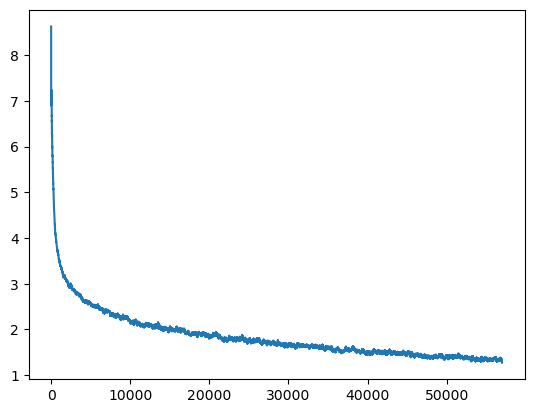

In [34]:
pd.Series(losses).ewm(100).mean().plot();

In [35]:
def translate(text, src_lang='spa_Latn', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [36]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

["na akumajuliikana computador neme'ejuin naa'in na wayuukana supula nama'anainjatuin wanee computador jeketka oju'ituin"]
['un joven deseaba tanto cierta tableta electronica que en secreto vendio uno de sus ri ones para comprarsela']
['los expertos han convencido a la gente de que la tecnologia es la ultima']


In [37]:
!ls -alsh $MODEL_SAVE_PATH

total 2.3G
4.0K drwxr-xr-x 2 jovyan users 4.0K Nov 25 06:18 .
4.0K drwxr-xr-x 6 jovyan users 4.0K Nov 25 06:18 ..
4.0K -rw-r--r-- 1 jovyan users  896 Nov 25 09:26 config.json
4.0K -rw-r--r-- 1 jovyan users  184 Nov 25 09:26 generation_config.json
2.3G -rw-r--r-- 1 jovyan users 2.3G Nov 25 09:26 pytorch_model.bin
4.7M -rw-r--r-- 1 jovyan users 4.7M Nov 25 09:26 sentencepiece.bpe.model
4.0K -rw-r--r-- 1 jovyan users 3.5K Nov 25 09:26 special_tokens_map.json
4.0K -rw-r--r-- 1 jovyan users  570 Nov 25 09:26 tokenizer_config.json


<h1 id="6.-Using-the-model">6. Testing the model</h1>

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [39]:
def fix_tokenizer(tokenizer, new_lang='wayuu_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [40]:
model_load_name = 'models/nllb_wayuu_COMP_NDU-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [41]:
def translate(text, src_lang='spa_Latn', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [42]:
t = "Hola como estas, ya hiciste la tarea de hoy"
print(translate(t, 'spa_Latn', 'wayuu_Cyrl'))

["anakaja muleka paa'inrule joolu'u tu paa'inrapu'ukat so'uka'i."]


In [43]:
translate(t, 'spa_Latn', 'wayuu_Cyrl', do_sample=True, num_beams=1, temperature=1.5)

["anamiashi joolu'u te'raaiwa pejee pumuin jainkuyuupa paa'in suka paainjuin tu pa'atapajakat anashi pukaaliijale pia suchikua pentiimoorolo. nnojotsu taya kasataalain atuma maa'unnaa mushi taya pupuleer"]

In [44]:
def batched_translate(texts, batch_size=16, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [45]:
esp_translated = batched_translate(df_test.esp, src_lang='spa_Latn', tgt_lang='wayuu_Cyrl')

  0%|          | 0/63 [00:00<?, ?it/s]

In [46]:
df_test['esp_translated'] = [translate(t, 'wayuu_Cyrl', 'spa_Latn')[0] for t in tqdm(df_test.wayuu)]
df_test['wayuu_translated'] = [translate(t, 'spa_Latn', 'wayuu_Cyrl')[0] for t in tqdm(df_test.esp)]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [48]:
print(bleu_calc.corpus_score(df_test['esp_translated'].tolist(), [df_test['esp'].tolist()]))
print(chrf_calc.corpus_score(df_test['esp_translated'].tolist(), [df_test['esp'].tolist()]))
print(bleu_calc.corpus_score(df_test['wayuu_translated'].tolist(), [df_test['wayuu'].tolist()]))
print(chrf_calc.corpus_score(df_test['wayuu_translated'].tolist(), [df_test['wayuu'].tolist()]))

BLEU = 9.72 40.4/16.6/8.9/5.5 (BP = 0.722 ratio = 0.754 hyp_len = 11751 ref_len = 15583)
chrF2++ = 28.11
BLEU = 8.84 37.5/15.9/8.0/4.4 (BP = 0.734 ratio = 0.764 hyp_len = 10790 ref_len = 14121)
chrF2++ = 33.62


In [49]:
pd.options.display.max_colwidth = 100

In [50]:
df_test.sample(10, random_state=42)[['wayuu', 'esp', 'wayuu_translated', 'esp_translated']]

,wayuu,esp,wayuu_translated,esp_translated
30721,pasiicho uwaashii waya junain aja itaa laairukujee,nosotros vamos en el mismo burro en busca de agua en el jaguey,o'unushi waya sulu'u puliikukolu junain achajawaa wuin sulu'u laakalu,nosotros teniamos pastillas en el chinchorro del jaguey
44987,suka nnojoleechin ja'yain chi kashikai,porque el primer arco delgado de la luna dificilmente sera visible entonces,suka nnojoluinjatuin we'ruin tu palajatka arco motso'o chi kashikai,porque la luna no aparecera
62862,wekirajaa sunain tu sumakat tu wiwuliakat shi'ipajee asakiraakaluirua tuu anale ma'in wakumajia ...,analice primero la respuesta que da la biblia a estas preguntas cuanto tiempo deberiamos vivir e...,wekirajaa palajana sunain tu sumakat tu wiwuliakat sunain putchikaluirua tuu je'rasu kakaliainna...,veamos la respuesta que da la biblia a las siguientes preguntas sobre la vida
65789,otta nakujawalin sumuin sunain soonooinjatuin sumaa tu namakat sumuin,ellos siempre le explicaban lo que esperaban que ella hiciera,akujushii naya waneepia sumuin tu saa'inrajatkat,ademas le prometieron que siempre la escucharian
70737,waa'inrule tia musu aka saa'in wa'waajule maleiwayaasu,y entonces estariamos cometiendo idolatria,nnojorule waa'inruin tia nnojoleena waya a'waajuin maleiwayaasu,si lo hicieramos seria como si le hicieramos una idolatria
40772,jamalu'ulu tia,que quiere decir esto,kasa sunainpunaaka tuu,en que sentido
45837,suka yaruttuin ma'in sukuwa'ipa wayuu so'ujee juyaka shii'iyatuin wamuin sulu'uluin supula saja'...,muchos quizas no hagan caso de lo que eso significa pero el hecho es que esta degeneracion sin p...,mayaapeje'e nnojoluin nayaawatuin saa'u tu sumakat tu wiwuliakat nnojotpeje'e natujaain aa'u shi...,la maldad que ha habido en el mundo desde demuestra que el reino de dios pronto eliminara la maldad
9900,shia ne'e tia,eso es todo,shia ne'e tia,eso es suficiente
71131,sunainjee wanoujainapain nunain cristo nnojoliinapa waya mmoluin seema arutkawaa nunainmuin chi ...,pablo dice tenemos esta franqueza de expresion y un acceso con confianza mediante nuestra fe en el,anuu nunuiki pablo watujaa aa'u tu shiimainkat suka wanoujain nunain maleiwa,el apostol pablo dijo que la fe en cristo nos permite acercarnos a dios con franqueza y confianza
26861,paapa namuin shi'yaase tateleepanain,dales mi numero,paapa tamuin noumeroin,dale la llave
